<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/3d_simple_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simplified 3D NeRF

In [ ]:
!pip install -q livelossplot

In [ ]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
from jax.lib import xla_bridge
import jax.numpy as np
from jax.experimental import stax
from jax.experimental import optimizers

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

import os

import numpy as onp

from jax.lib import xla_bridge
print(f'Using {xla_bridge.get_backend().platform}')

rng = random.PRNGKey(0)

Using gpu


# Load Data

(7, 400, 400, 3) (13, 400, 400, 3) 555.5555155968841


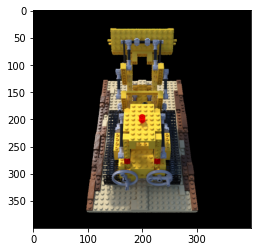

In [ ]:
filename = 'lego_400.npz'
if not os.path.exists(filename):
    !gdown --id 108jNfjPITTsTA0lE6Kpg7Ei53BUVL-4n # Lego

data = np.load(filename)
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]

images, val_images, test_images = np.split(images[...,:3], [100,107], axis=0)
poses, val_poses, test_poses = np.split(poses, [100,107], axis=0)

print(val_images.shape, test_images.shape, focal)
plt.imshow(test_images[0,...])
plt.show()

# Rendering Functions

In [ ]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1, 2,))

training_rays = np.stack([get_rays(H,W,focal,pose) for pose in poses], 1)
training_data = np.concatenate([training_rays, images[None]])
training_data = np.moveaxis(training_data, 0, -2)
training_data = onp.array(np.reshape(training_data, [-1, 3, 3]))
onp.random.shuffle(training_data)
training_data = np.array(training_data)

In [ ]:
def render_rays(apply_fn, params, avals, bvals, key, rays, near, far, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays
    
    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(key, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = np.reshape(pts, [-1,3])
    if avals is not None:
        pts_flat = np.concatenate([avals * np.sin(pts_flat @ bvals.T), 
                                   avals * np.cos(pts_flat @ bvals.T)], axis=-1)
    raw = apply_fn(params, pts_flat)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1.-alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2) 
    acc_map = np.sum(weights, -1)
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(params, avals, bvals, key, rays, rand, allret):
    return render_rays(apply_fn, params, avals, bvals, key, rays, near=2., far=6., N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(5, 6,))

def render_fn(params, avals, bvals, key, rays, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(params, avals, bvals, key, rays[:,i:i+chunk], rand, True)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets



#Network Definition

In [ ]:
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(4))
    return stax.serial(*layers)

In [ ]:
def loss_fn(params, avals, bvals, key, rays, target, stratified):
    rgb = render_fn_inner(params, avals, bvals, key, rays, stratified, False)
    l = np.mean(np.square(rgb - target))
    return l

def train_model(lr, iters, avals, bvals, stratified, name='', plot_groups=None):
    rng = random.PRNGKey(0)
    if bvals is not None:
        init_shape = (-1, bvals.shape[0]*2)
    else:
        init_shape = (-1, 3)
    _, net_params = init_fn(rng, init_shape)

    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_state = opt_init(net_params)

    @jit
    def step_fn(i, opt_state, avals, bvals, key, rays, target):
        params = get_params(opt_state)
        g = grad(loss_fn)(params, avals, bvals, key, rays, target, stratified)
        return opt_update(i, g, opt_state)

    if plot_groups is not None:
        plot_groups['PSNR'].append(f'{name}')
    b_i = 0
    xs = []
    psnrs = []
    import time
    t = time.time()
    t0 = t
    for i in range(iters+1):
        batch = training_data[b_i:b_i+batch_size]
        b_i += batch_size
        rays = np.moveaxis(batch[:,:2], 1, 0)
        target = batch[:,2]
        if b_i >= training_data.shape[0]:
            b_i = 0

        rng, key = random.split(rng)
        opt_state = step_fn(i, opt_state, avals, bvals, key, rays, target)  
        
        if i%1000==0 or i==iters:
            psnr = []
            print(i, (time.time() - t) / 200, 'secs per iter', (time.time()-t0)/60., 'total mins')
            num_vals = val_poses.shape[0] if i==iters else 1
            for v in range(num_vals):
                # Render the holdout view for logging
                rays = get_rays(H, W, focal, val_poses[v,...])
                rng, key = random.split(rng)
                rgb, depth, acc = render_fn(get_params(opt_state), avals, bvals, key, rays, False)
                
                loss = np.mean(np.square(rgb - val_images[v,...]))
                psnr.append(-10. * np.log10(loss))
            psnr = np.mean(np.array(psnr))
            psnrs.append(psnr)
            xs.append(i)
            if plot_groups is not None:
                plotlosses_model.update({f'{name}':psnr}, current_step=i)
                plotlosses_model.send()
            t = time.time()
    results = {
        'state': get_params(opt_state),
        'psnrs': psnrs,
        'avals': avals,
        'bvals': bvals,
        'val_image': rgb,
        'xs': xs
    }
    return results

## Train network with different embeddings

Our 3D input embedding is of the form: \
> $\gamma(\mathbf v) = (a_0 \sin(\pi b_0^\top \mathbf v), a_0 \cos(\pi b_0^\top \mathbf v),a_1 \sin(\pi b_1^\top \mathbf v), a_1 \cos(\pi b_1^\top \mathbf v),...)$

This creates a kernel of the form: \
> $k_\gamma(\mathbf v_1, \mathbf v_2) = \sum_{i=1}^m a_i^2 \cos(\pi b_i^\top (\mathbf v_1 - \mathbf v_2))$

In [ ]:
#@title Train Models
disable_jit = False #@param {type:"boolean"}

live_plot = True #@param {type:"boolean"}
reset_plots = True #@param {type:"boolean"}

#@markdown ##Network Params
lr =  5e-4#@param
batch_size = 1024 #@param
N_samples = 128 #@param
training_steps =  50000#@param
num_layers =  4#@param
layer_width = 256 #@param
stratified_sampling = True #@param {type:"boolean"}
rotate = True #@param {type:"boolean"}

#@markdown ##Encoder Params
embedding_size = 256 #@param
max_posenc_log_scale =  8#@param
#@markdown gaussian_scales should be a list of scales (things like np.arange(...) allowed)
gaussian_scales = [38] #@param
#@markdown
include_no_encoding = True #@param {type:"boolean"}
include_basic = True #@param {type:"boolean"}
include_posenc = False #@param {type:"boolean"}
include_new_posenc = True #@param {type:"boolean"}
include_gaussian = True #@param {type:"boolean"}

config.update('jax_disable_jit', disable_jit)

init_fn, apply_fn = make_network(num_layers, layer_width)

enc_dict = {}

if include_basic:
    bvals = np.eye(3)
    avals = np.ones((bvals.shape[0])) 
    enc_dict['basic'] = (avals, bvals)

if include_posenc:
    bvals = 2.**np.arange(max_posenc_log_scale)
    bvals = np.reshape(np.eye(3)*bvals[:,None,None], [len(bvals)*3, 3])
    avals = np.ones((bvals.shape[0])) 
    enc_dict['posenc'] = (avals, bvals)

if include_new_posenc:
    bvals = 2.**np.linspace(0,max_posenc_log_scale,embedding_size//3) - 1
    bvals = np.reshape(np.eye(3)*bvals[:,None,None], [len(bvals)*3, 3])
    avals = np.ones((bvals.shape[0]))
    if rotate:
        rot = np.array([[(2**.5)/2,-(2**.5)/2,0],[(2**.5)/2,(2**.5)/2,0],[0,0,1]])
        bvals = bvals @ rot.T
        rot = np.array([[1,0,0],[0,(2**.5)/2,-(2**.5)/2],[0,(2**.5)/2,(2**.5)/2]])
        bvals = bvals @ rot.T
    enc_dict['posenc_new'] = (avals, bvals)

if include_gaussian:
    bvals = random.normal(rng, (embedding_size, 3))
    avals = np.ones((bvals.shape[0]))
    for scale in gaussian_scales:
        enc_dict['gaussian_%.2f' % scale] = (avals, bvals * scale)

if live_plot:
    if reset_plots:
        plt_groups = {'PSNR':[]}
        # plotlosses_model = PlotLosses()
        plotlosses_model = PlotLosses(groups=plt_groups)
else:
    plt_groups = None

if reset_plots:
    outputs = {}
if include_no_encoding:
    outputs['no_encoding'] = train_model(lr, training_steps, None, None, stratified_sampling, name='no encodings', plot_groups=plt_groups)

for k in tqdm(enc_dict, leave=False):
    outputs[k] = train_model(lr, training_steps, *enc_dict[k], stratified_sampling, name=k, plot_groups=plt_groups)

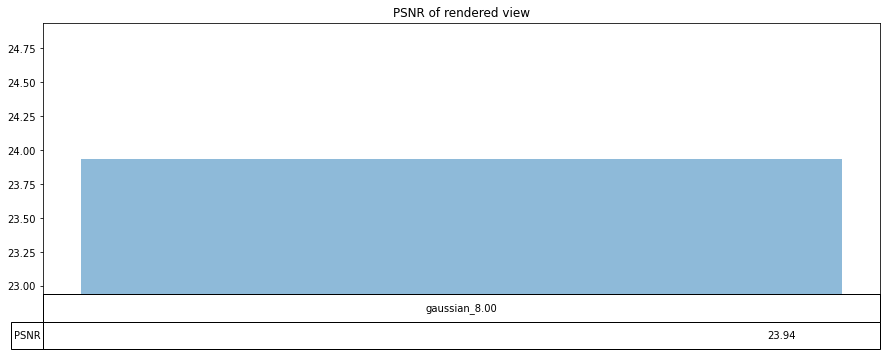

----------------------------------------
                  Test
----------------------------------------


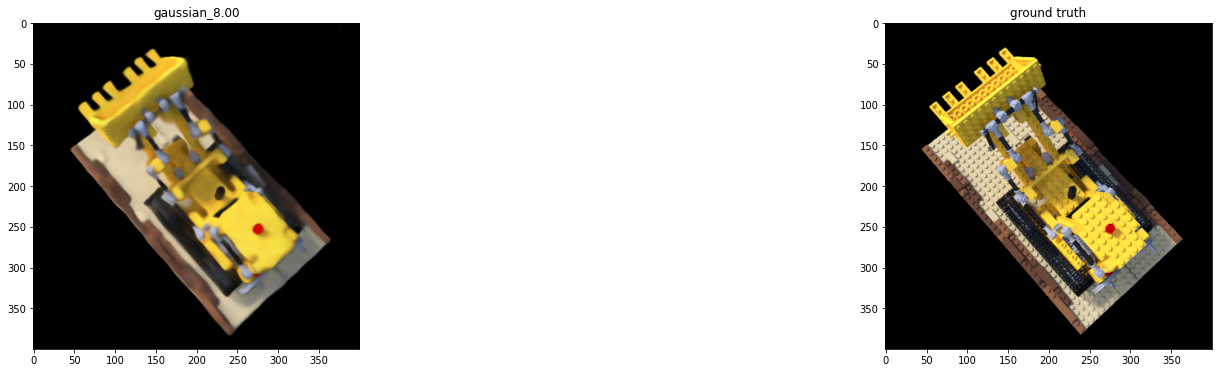

In [ ]:
#@title Plot Results

bar_graph = True #@param {type:"boolean"}
renders_viz = True #@param {type:"boolean"}

names = list(outputs.keys())
xvals = np.arange(len(names))
test_value = np.array([outputs[n]['psnrs'][-1] for n in names])
inds = np.argsort(test_value)
names_sort = [names[i] for i in inds]

if bar_graph:
    plt.figure(figsize=(15,5))
    plt.bar(xvals, test_value[inds], alpha=.5)
    # plt.xticks(xvals, names_sort, rotation=60)
    plt.xticks([])
    plt.ylim(test_value.min()-1, test_value.max()+1)
    plt.title(f'PSNR of rendered view')
    plt.table(cellText=[['%.2f' % x for x in test_value[inds].tolist()]],
        rowLabels=['PSNR'],
        colLabels=names_sort,
        loc='bottom',
        bbox=[0, -.2, 1, 0.2])
    plt.show()

if renders_viz:
    print('----------------------------------------')
    print('                  Test')
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(outputs[p]['val_image'])
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(testimg)
    plt.title('ground truth')
    plt.show()

# Grid Search

In [ ]:
#@title Train Models
disable_jit = False #@param {type:"boolean"}

live_plot = True #@param {type:"boolean"}
reset_plots = True #@param {type:"boolean"}

#@markdown ##Network Params
lr =  5e-4#@param
batch_size = 1024 #@param
N_samples = 128 #@param
training_steps =  50000#@param
num_layers =  4#@param
layer_width = 256 #@param
stratified_sampling = True #@param {type:"boolean"}

#@markdown ##Encoder Params
embedding_size = 256 #@param
#@markdown gaussian_scales should be a list of scales (things like np.arange(...) allowed)
gaussian_scales = [8,12,14,15,16,17,18,19,20,21,22,23,24,26,28,32] #@param

config.update('jax_disable_jit', disable_jit)

init_fn, apply_fn = make_network(num_layers, layer_width)

enc_dict = {}

bvals = random.normal(rng, (embedding_size, 3))
avals = np.ones((bvals.shape[0]))
for scale in gaussian_scales:
    enc_dict['gaussian_%.2f' % scale] = (avals, bvals * scale)

if live_plot:
    if reset_plots:
        plt_groups = {'PSNR':[]}
        # plotlosses_model = PlotLosses()
        plotlosses_model = PlotLosses(groups=plt_groups)
else:
    plt_groups = None

if reset_plots:
    outputs = {}
if include_no_encoding:
    outputs['no_encoding'] = train_model(lr, training_steps, None, None, stratified_sampling, name='no encoding', plot_groups=plt_groups)

grid_psnrs = []
for k in tqdm(enc_dict, leave=False):
    out = train_model(lr, training_steps, *enc_dict[k], stratified_sampling, name=k, plot_groups=plt_groups)
    grid_psnrs.append(out['psnrs'][-1])

plt.plot(gaussian_scales, grid_psnrs)
print('best scale', gaussian_scales[np.argmax(np.array(grid_psnrs))])


# Paper Experiments

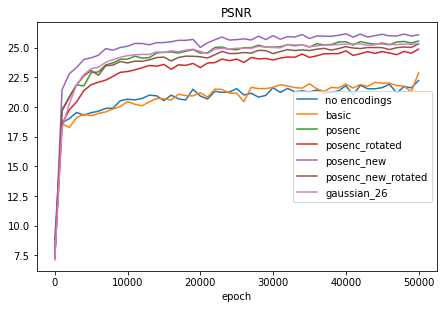

PSNR
	no encodings     	 (min:    8.809, max:   22.417, cur:   22.231)
	basic            	 (min:    7.416, max:   22.882, cur:   22.882)
	posenc           	 (min:    7.428, max:   25.560, cur:   25.560)
	posenc_rotated   	 (min:    7.472, max:   24.879, cur:   24.879)
	posenc_new       	 (min:    1.000, max:   26.243, cur:   26.087)
	posenc_new_rotated 	 (min:    7.154, max:   25.358, cur:   25.317)
	gaussian_26      	 (min:    7.162, max:   25.428, cur:   25.340)


In [ ]:
live_plot = True
reset_plots = True

training_steps = 50000

lr =  5e-4
lr_no_encoding = 1e-2
lr_basic = 5e-3

batch_size = 1024
N_samples = 128
num_layers =  4
layer_width = 256
stratified_sampling = True

embedding_size = 256
max_posenc_log_scale = 8
gaussian_scale = 26

init_fn, apply_fn = make_network(num_layers, layer_width)

enc_dict = {}

bvals = np.eye(3)
avals = np.ones((bvals.shape[0])) 
enc_dict['basic'] = (avals, bvals)

bvals = 2.**np.arange(max_posenc_log_scale+1)
bvals = np.reshape(np.eye(3)*bvals[:,None,None], [len(bvals)*3, 3])
avals = np.ones((bvals.shape[0])) 
enc_dict['posenc'] = (avals, bvals)

bvals = 2.**np.arange(max_posenc_log_scale+1)
bvals = np.reshape(np.eye(3)*bvals[:,None,None], [len(bvals)*3, 3])
avals = np.ones((bvals.shape[0])) 
rot = np.array([[(2**.5)/2,-(2**.5)/2,0],[(2**.5)/2,(2**.5)/2,0],[0,0,1]])
bvals = bvals @ rot.T
rot = np.array([[1,0,0],[0,(2**.5)/2,-(2**.5)/2],[0,(2**.5)/2,(2**.5)/2]])
bvals = bvals @ rot.T
enc_dict['posenc_rotated'] = (avals, bvals)

bvals = 2.**np.linspace(0,max_posenc_log_scale,embedding_size//3) - 1
bvals = np.reshape(np.eye(3)*bvals[:,None,None], [len(bvals)*3, 3])
avals = np.ones((bvals.shape[0]))
enc_dict['posenc_new'] = (avals, bvals)

bvals = 2.**np.linspace(0,max_posenc_log_scale,embedding_size//3) - 1
bvals = np.reshape(np.eye(3)*bvals[:,None,None], [len(bvals)*3, 3])
rot = np.array([[(2**.5)/2,-(2**.5)/2,0],[(2**.5)/2,(2**.5)/2,0],[0,0,1]])
bvals = bvals @ rot.T
rot = np.array([[1,0,0],[0,(2**.5)/2,-(2**.5)/2],[0,(2**.5)/2,(2**.5)/2]])
bvals = bvals @ rot.T
enc_dict['posenc_new_rotated'] = (avals, bvals)

bvals = random.normal(rng, (embedding_size, 3))
avals = np.ones((bvals.shape[0]))
enc_dict[f'gaussian_{gaussian_scale}'] = (avals, bvals * gaussian_scale)

if live_plot:
    if reset_plots:
        plt_groups = {'PSNR':[]}
        plotlosses_model = PlotLosses(groups=plt_groups)
else:
    plt_groups = None

if reset_plots:
    outputs_paper = {}

outputs_paper['no_encoding'] = train_model(lr_no_encoding, training_steps, None, None, stratified_sampling, name='no encodings', plot_groups=plt_groups)

for k in tqdm(enc_dict, leave=False):
    if 'basic' in k:
        exp_lr = lr_basic
    else:
        exp_lr = lr
    outputs_paper[k] = train_model(exp_lr, training_steps, *enc_dict[k], stratified_sampling, name=k, plot_groups=plt_groups)

In [ ]:
import imageio
for k in outputs_paper:
    psnr = []
    num_test = test_poses.shape[0]
    state = outputs_paper[k]['state']
    avals = outputs_paper[k]['avals']
    bvals = outputs_paper[k]['bvals']
    for v in range(num_test):
        rays = get_rays(H, W, focal, test_poses[v,...])
        rng, key = random.split(rng)
        rgb, depth, acc = render_fn(state, avals, bvals, key, rays, False)
        
        loss = np.mean(np.square(rgb - test_images[v,...]))
        psnr.append(-10. * np.log10(loss))
        if v in [1,4,6]:
            imageio.imwrite(f'nerf_{k}_{v}.png', rgb)
    psnr_mean = np.mean(np.array(psnr))
    psnr_std = np.std(np.array(psnr))
    print(f'    {k}:             %.3f,    std: %.3f' % (psnr_mean, psnr_std))

    no_encoding:             22.405,    std: 0.919


    basic:             23.157,    std: 0.903


    posenc:             25.598,    std: 0.762


    posenc_rotated:             24.805,    std: 0.882


    posenc_new:             26.265,    std: 0.911


    posenc_new_rotated:             25.280,    std: 0.826


    gaussian_26:             25.475,    std: 0.891
